# Simple topography and geology generator #
C. Fandel 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import sys
import math
import pyevtk   #optional - for exporting to VTK format for visualization in 3D


In [2]:
def point2index(point, xmin,ymin,zmin, dx,dy,dz):
    '''Convert from x,y,z coordinates to i,j,k indices.'''
    x   = point[0]
    y   = point[1]
    z   = point[2]
    col = int((x - xmin) // dx)
    row = int((y - ymin) // dy)
    lay = int((z - zmin) // dz)
    
    return [col, row, lay]

def index2point(index, xmin,ymin,zmin, dx,dy,dz):
    '''Convert from i,j,k indices to x,y,z coordinates.'''
    col   = float(index[0])
    row   = float(index[1])
    lay   = float(index[2])
    x     = xmin + (col*dx)
    y     = ymin + (row*dy)
    z     = zmin + (lay*dz)
    
    return [x,y,z]

In [3]:
#Optional:
def export2vtk(xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres, vtk_path, a=None):
    '''Export gempy lith_block array to VTK file (for viewing in e.g. ParaView).
    
    Inputs:
    sol:      list of model dimensions [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    vtk_path: filepath to save VTK file to (must not include any file extension)
    a:        array to export (such as a cropped lith_block)
    
    Returns:
    VTK file representing the exported array'''
    
    #Create VTK cells info
    dx   = (xmax-xmin)/xres                 #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)      #calculate x coordinate values of the boundaries between cells
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Format array for export:
    g = a.copy()                         #make a copy to avoid messing up original

    #Debugging checks:
    #print('x:', xmin,xmax,xres,dx)
    #print('y:', ymin,ymax,yres,dy)
    #print('z:', zmin,zmax,zres,dz)
    #print('shape of array to export:', g.shape)
    #plt.imshow(g[:,:,0])
    
    pyevtk.hl.gridToVTK(vtk_path, xvals, yvals, zvals, cellData={'data': g}) #export to VTK

## Generate or load geology ##
In progress

In [4]:
#Define grid:
model = 'valley1'

if model == 'valley1':
    xmin = 0;  xres = 100;  dx = 10.0;  xmax = xmin + xres*dx
    ymin = 0;  yres = 80;   dy = 10.0;  ymax = ymin + yres*dy   
    zmin = 0;  zres = 60;   dz = 10.0;  zmax = zmin + zres*dz
    topo    = 'generate'
    contact = 'generate'
    geology = 'generate'
    crop    = True
    getmap  = True
    
if model == 'gottesacker':
    xmin = 578262.5;  xres = 251;  dx = 50.0;  xmax = xmin + xres*dx
    ymin = 5240037.5; yres = 200;  dy = 50.0;  ymax = ymin + yres*dy   
    zmin = 800;       zres = 52;   dz = 27.5;  zmax = zmin + zres*dz
    topo    = 'inputs/gottesacker/dem200x251.csv'
    contact = 'extract'
    geology = 'inputs/gottesacker/geo200x251x52.gslib'
    crop    = False
    getmap  = True
    dim     = 3
    
if model == 'betteraz':
    dx = 20.0;  xmin = 572510-(dx/2);    xres = 300;  xmax = xmin + xres*dx
    dy = 20.0;  ymin = 250010 - (dy/2);  yres = 300;  ymax = ymin + yres*dy   
    dz = 20.0;  zmin = 0;                zres = 100;  zmax = zmin + zres*dz
    topo    = 'inputs/betteraz/random_dem300x300.csv'
    contact = None
    geology = 'inputs/betteraz/betteraz_2D_z430.gslib'  #need 3D gslib file for Betteraz?
    crop    = False
    getmap  = False
    dim     = 2

DEM array: (100, 80) 183.0 600.0
DEM index array: (100, 80) 17 59
Contact array: (100, 80) 221.0 360.0
Geology array: (100, 80, 60) 1.0 3.0
Geology map: (100, 80) 1.0 3.0


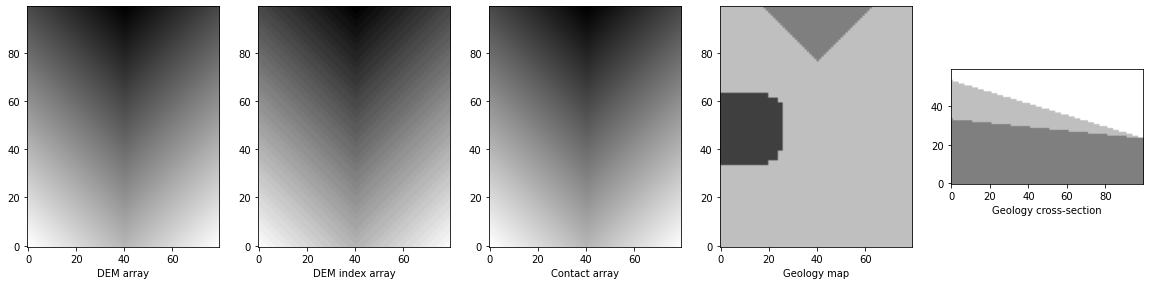

In [5]:
f = plt.figure(figsize=(20,5))

#Create 2D topography array:
if topo == 'generate':
    dem = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
    mx = -0.3 * dx                     #set the slope in the x direction (west to east) (0.25)
    my = -0.3 * dy                     #set the slope in the y direction (north to south) (0.25)
    valley  = yres//2                   #set which row to put the valley in
    for ix in range(xres):               #move west to east along x indices (columns)
        dem[ix,:] = mx*ix + dem[0,0]     #change the elevation in each column along a slope, starting from the max elevation
        for iy in range(0,valley+1):     #move down rows towards valley (north to south)
            dem[ix,iy] = my*iy + dem[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
    for iy in range(valley,yres):            #move down y indices (rows) away from valley (south to north)
        dem[:,iy] = dem[:,yres-iy]           #insert a mirror image of the north side of the valley    
else:
    dem = np.genfromtxt(topo, delimiter=',')
    dem = np.rot90(dem,k=-1)
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
f.add_subplot(151, aspect='equal')
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')

#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dem[:,iy]):
        [xind,yind,zind] = point2index([0,0,z], xmin,ymin,zmin, dx,dy,dz)  #convert x,y,z coord to array indices
        idem[ix,iy] = zind-1 #correct to be index below
print('DEM index array:', idem.shape, idem.min(), idem.max())    #print dimensions
f.add_subplot(152, aspect='equal')
plt.imshow(idem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM index array')

#Create 2D array of lower contact between karst and nonkarst:
if contact == 'generate':
    zstart = zmax - (zmax-zmin)//2.5  #max elev of contact
    zcontact = np.full((xres,yres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
    mx = -0.1 * dx                 #set the slope in the x direction (west to east)
    my = -0.1 * dy                 #set the slope in the y direction (north to south)
    valley  = yres//2              #set which row to put the valley in
    for ix in range(xres):                        #move west to east along columns
        zcontact[ix,:] = mx*ix + zcontact[0,0]    #change the elevation in each column along a slope, starting from the max elevation
        for iy in range(ymin,valley+1):           #move down rows towards valley (north to south)
            zcontact[ix,iy] = my*iy + zcontact[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
    for iy in range(valley,yres):                      #move down rows away from valley (south to north)
        zcontact[:,iy] = zcontact[:,yres-iy]           #insert a mirror image of the north side of the valley
    print('Contact array:', zcontact.shape, zcontact.min(), zcontact.max())   
    f.add_subplot(153, aspect='equal')
    plt.imshow(zcontact, origin='lower', cmap='gray') #white = limestone
    plt.xlabel('Contact array')

#Create 3D geology array:
if geology == 'generate':
    out       = 0
    limestone = 1
    shale     = 2
    granite   = 3
    #Convert from coordinates to cell indices:
    icontact = np.empty((xres,yres))
    for iy in range(yres):
        for ix,z in enumerate(zcontact[:,iy]):
            [xind,yind,zind] = point2index([0,0,z], xmin,ymin,zmin, dx,dy,dz)  #convert x,y,z coord to array indices
            icontact[ix,iy] = zind - 1
    #Create 3D geology array (the integer in each cell indicates the formation present in that cell):
    geo = np.empty((xres,yres,zres))   #set empty 3D array of model dimensions
    for ix in range(xres):            #loop over cols, rows, & layers
        for iy in range(yres):
            for iz in range(zres):             #for each cell, 
                if iz <= icontact[ix,iy]:    #if layer is below the contact index (i.e. has a lower index),
                    geo[ix,iy,iz] = shale        #assign for shale
                if iz > icontact[ix,iy]:     #if layer is above the contact index (i.e. has a higher index),
                    geo[ix,iy,iz] = limestone        #assign for limestone
    geo[40:60, 0:26] = granite                     #insert a block of shale in one corner to make array asymmetrical
    geo[36:62, 0:24] = granite                     #insert a block of shale in one corner to make array asymmetrical
    geo[34:64, 0:20] = granite                     #insert a block of shale in one corner to make array asymmetrical
else:
    geo = pd.read_csv(geology, skiprows=2)  #read in gslib file to pandas df without header rows
    geo = geo.values                                        #get an array of the values
    if dim == 2:
        geo = np.reshape(geo,(xres,yres),order='F') #reshape to xy grid using Fortran ordering
    else:
        geo = np.reshape(geo,(yres,xres,zres),order='F') #reshape to xyz grid using Fortran ordering
    geo = np.rot90(geo, k=-1)
print('Geology array:', geo.shape, geo.min(), geo.max())  

#Extract contact surface from geology array:
if contact == 'extract':
    limestone = 2   #contact describes bottom surface of this unit
    zcontact = np.zeros((xres,yres), dtype='float')
    for ix in range(xres):
        for iy in range(yres):
            for iz in range(zres):
                if (geo[ix,iy,iz] == limestone) and (geo[ix,iy,iz-1] != limestone):
                    [x,y,z] = index2point([ix,iy,iz-1], xmin,ymin,zmin, dx,dy,dz)
                    zcontact[ix,iy] = z
    zcontact[zcontact < zmin] = np.nan
    print('Contact array:', zcontact.shape, np.nanmin(zcontact), np.nanmax(zcontact))
    f.add_subplot(153, aspect='equal')
    plt.imshow(zcontact, origin='lower', cmap='gray') #white = limestone
    plt.xlabel('Contact surface')

#Get 2D geologic map of formation present at land surface based on DEM
if getmap == True:
    geomap = np.empty((xres,yres))
    for ix in range(xres):
        for iy in range(yres):
            iz = idem[ix,iy]
            geomap[ix,iy] = geo[ix,iy,iz]
    print('Geology map:', geomap.shape, geomap.min(), geomap.max())
    f.add_subplot(154, aspect='equal')
    plt.imshow(geomap, origin='lower', cmap='gray_r', vmin=0,vmax=4) #white = limestone
    plt.xlabel('Geology map')

#Crop off everything above land surface:
if crop == True:
    geocrop = geo.copy()
    for ix in range(xres):
        for iy in range(yres):
            for iz in range(zres):
                if iz > idem[ix,iy]:    #if above land surface
                    geocrop[ix,iy,iz] = out
    f.add_subplot(155, aspect='equal')
    plt.imshow(np.flipud(np.rot90(geocrop[:,60,:])), origin='lower', cmap='gray_r', vmin=0,vmax=4)
    plt.xlabel('Geology cross-section')
elif dim == 2:
    f.add_subplot(155, aspect='equal')
    plt.imshow(np.flipud(np.rot90(geo)), origin='lower', cmap='gray_r')
    plt.xlabel('Geology map')
else:
    f.add_subplot(155, aspect='equal')
    plt.imshow(np.flipud(np.rot90(geo[:,yres//2,:])), origin='lower', cmap='gray_r')
    plt.xlabel('Geology cross-section')

In [11]:
#Get inlets and outlets:
dim = 'load3D'    #load3D, calc3D, or 2

#Inlets
if dim == 2:
    inlets = np.loadtxt('inputs/betteraz/inlets2D.txt') #load 2D inlets
elif dim == 'calc3D':
    inlets = np.loadtxt('inputs/valley1/inlets2D.txt') #load 2D inlets
    print('2D inlets:', inlets)
    inlets3D = np.empty((len(inlets),3))
    for i,inlet in enumerate(inlets):                  
        [xind,yind,zind] = point2index([inlet[0],inlet[1],0], xmin,ymin,zmin, dx,dy,dz)   #get inlet indices
        inlet = np.append(inlet,dem[int(xind),int(yind)])   #get inlet elevation
        inlets3D[i] = inlet
elif dim == 'load3D':
    inlets3D = np.loadtxt('inputs/gottesacker/inlets3D.txt') #load 3D inlets
print('3D inlets:', inlets3D)

#Outlets:
if dim == 2:
    outlets = np.loadtxt('inputs/betteraz/outlets2D.txt') #load 2D inlets
elif dim == 'calc3D':
    outlets = np.loadtxt('inputs/valley1/outlets2D.txt') #load 2D inlets
    if len(outlets.shape) == 1:  #if there is only one outlet
        outlets = np.asarray([outlets])
    print('2D outlets:', outlets)
    outlets3D = np.empty((len(outlets),3))
    for i,outlet in enumerate(outlets):
        [xind,yind,zind] = point2index([outlet[0],outlet[1],0], xmin,ymin,zmin, dx,dy,dz)
        outlet = np.append(outlet,dem[int(xind),int(yind)])
        outlets3D[i] = outlet
elif dim == 'load3D':
    outlets3D = np.loadtxt('inputs/gottesacker/outlets3D.txt') #load 3D outlets
    if len(outlets3D.shape) == 1:  #if there is only one outlet
        outlets3D = np.asarray([outlets3D])
print('3D outlets:', outlets3D)

3D inlets: [[5.8288080e+05 5.2430551e+06 1.8250000e+03]
 [5.8153660e+05 5.2445996e+06 1.5500000e+03]
 [5.8336320e+05 5.2459179e+06 1.7150000e+03]
 [5.8405440e+05 5.2470566e+06 1.3850000e+03]
 [5.8536700e+05 5.2481518e+06 1.8770000e+03]]
3D outlets: [[5.87747520e+05 5.24496363e+06 1.12000000e+03]
 [5.88123610e+05 5.24563824e+06 1.08000000e+03]
 [5.88979500e+05 5.24673086e+06 1.03500000e+03]]


### Plot for Paper 2 ###

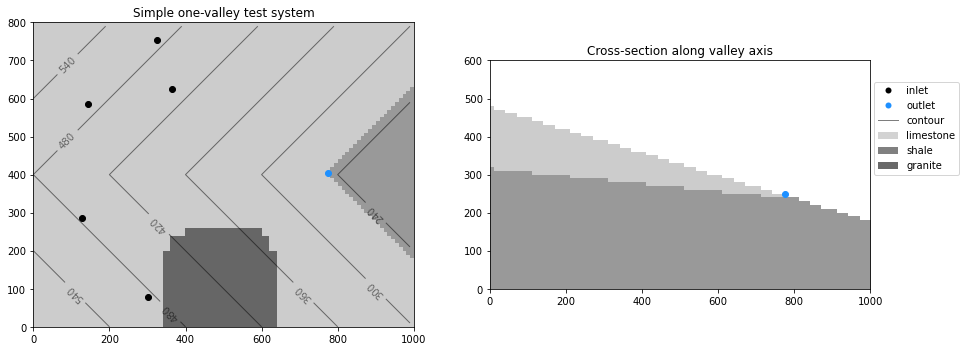

In [234]:
#Valley 1
f = plt.figure(figsize=(15,15))

#Map
f.add_subplot(121, aspect='equal')
plt.title('Simple one-valley test system')

plt.imshow(np.flipud(np.rot90(geomap)), origin='lower', extent=[xmin,xmax,ymin,ymax], cmap='gray_r', vmin=0,vmax=5)
xvals = np.arange(xmin,xmax,dx)      #calculate x coordinate values of the boundaries between cells
yvals = np.arange(ymin,ymax,dy)
c = plt.contour(xvals,yvals, np.flipud(np.rot90(dem)), colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)

plt.scatter(inlets3D[:,0], inlets3D[:,1], c='k')
plt.scatter(outlets3D[:,0], outlets3D[:,1], c='dodgerblue')

#X-sec
f.add_subplot(122, aspect='equal')
plt.title('Cross-section along valley axis')

plt.imshow(np.flipud(np.rot90(geocrop[:,40,:])), origin='lower', extent=[xmin,xmax,zmin,zmax], cmap='gray_r', vmin=0,vmax=5)
#plt.scatter(inlets3D[:,0],  inlets3D[:,2], c='k')
plt.scatter(outlets3D[:,0], outlets3D[:,2], c='dodgerblue')


legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightgray', label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='shale'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='granite')]
plt.legend(handles=legend, loc=[1.01,0.5])


(60, 100)
[0. 1. 2.]


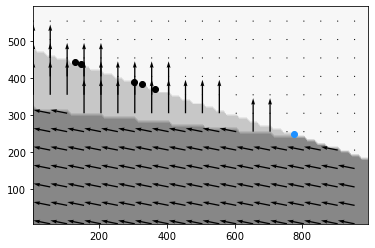

In [297]:
#Export cross-section
g = np.flipud(np.rot90(geocrop[:,40,:]))
print(g.shape)
print(np.unique(g))
#np.savetxt('inputs/valley1/xsec/geo'+str(g.shape[0])+'x'+str(g.shape[1])+'.csv', g, delimiter=',')  #export 2D geologic map as csv

inletsXsec = np.empty((len(inlets3D),2))
for i,inlet in enumerate(inlets3D):                  
        [xind,yind,zind] = point2index([inlet[0],inlet[1],inlet[2]], xmin,ymin,zmin, dx,dy,dz)   #get inlet indices
        z = dem[xind,40] #get elevation at x-sec line
        inlet = np.append(inlet[0],z)   #set inlet x and z
        inletsXsec[i] = inlet
i = inletsXsec
#np.savetxt('inputs/valley1/xsec/inlets2D.txt', i, delimiter=' ', fmt='%.1f')  

o = outlets3D[:,(0,2)]
#np.savetxt('inputs/valley1/xsec/outlets2D.txt', o, delimiter=' ', fmt='%.1f')  #export 2D geologic map as csv
       
d     = np.ones((zres,xres))
for iz in range(zres):
    for ix in range(xres):
        d[iz,ix] = iz*3
        if iz <= 35:    
            d[iz,ix] = 35*3
#np.savetxt('inputs/valley1/xsec/dem60x100.csv', dem, delimiter=',', fmt='%.1f')

## Gottesacker plots for Paper 2 ##

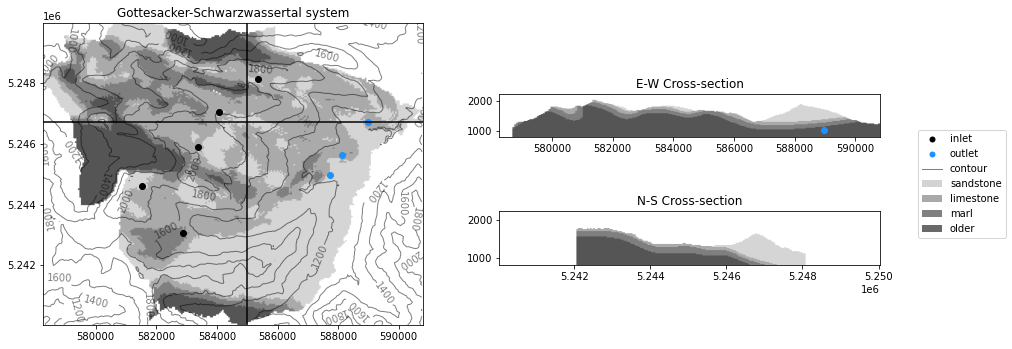

In [19]:
#Gottesacker
f = plt.figure(figsize=(15,15))

#Map
f.add_subplot(2,2, (1,3), aspect='equal')
plt.title('Gottesacker-Schwarzwassertal system')

plt.imshow(np.rot90(geomap), origin='lower', extent=[xmin,xmax,ymin,ymax], cmap='gray_r', vmin=0,vmax=6)
xvals = np.arange(xmin,xmax,dx)      #calculate x coordinate values of the boundaries between cells
yvals = np.arange(ymin,ymax,dy)
c = plt.contour(xvals,yvals, np.rot90(dem), colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
section1 = 5246730.86
section2 = 585000.0
plt.plot([xmin,xmax],[section1,section1], c='k')
plt.plot([section2,section2],[ymin,ymax], c='k')


plt.scatter(inlets3D[:,0], inlets3D[:,1], c='k')
plt.scatter(outlets3D[:,0], outlets3D[:,1], c='dodgerblue')


#X-sec
f.add_subplot(2,2,2, aspect='equal', anchor='S')
plt.title('E-W Cross-section')

[ix,iy,iz] = point2index([0,section1,0],  xmin,ymin,zmin, dx,dy,dz)  #get index of cross-section location
plt.imshow(np.fliplr(np.rot90(geo[iy,:,:],k=-1)), origin='lower', extent=[xmin,xmax,zmin,zmax],  cmap='gray_r', vmin=0,vmax=6) #extent=[xmin,xmax,zmin,zmax],
#plt.scatter(inlets3D[:,0],  inlets3D[:,2], c='k')
plt.scatter(outlets3D[2,0], outlets3D[2,2], c='dodgerblue')

#X-sec
f.add_subplot(2,2,4, aspect='equal', anchor='N')
plt.title('N-S Cross-section')

[ix,iy,iz] = point2index([section2,0,0],  xmin,ymin,zmin, dx,dy,dz)  #get index of cross-section location
plt.imshow(np.fliplr(np.rot90(geo[:,ix,:],k=-1)), origin='lower', extent=[ymin,ymax,zmin,zmax],  cmap='gray_r', vmin=0,vmax=6) #extent=[xmin,xmax,zmin,zmax],
#plt.scatter(inlets3D[-1,1],  inlets3D[-1,2], c='k')
#plt.scatter(outlets3D[2,1], outlets3D[2,2], c='dodgerblue')


legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightgray', label='sandstone'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='marl'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='older')]
plt.legend(handles=legend, loc=[1.1,0.5])

## Betteraz plots for Paper 2 ##


In [ ]:
#Betteraz
f = plt.figure(figsize=(15,15))

#Map
f.add_subplot(2,2, (1,3), aspect='equal')
plt.title('Betteraz system')

plt.imshow(np.rot90(geomap), origin='lower', extent=[xmin,xmax,ymin,ymax], cmap='gray_r', vmin=0,vmax=6)
xvals = np.arange(xmin,xmax,dx)      #calculate x coordinate values of the boundaries between cells
yvals = np.arange(ymin,ymax,dy)
c = plt.contour(xvals,yvals, np.rot90(dem), colors=['k'], alpha=0.5, linewidths=1)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
section1 = 5246730.86
section2 = 585000.0
plt.plot([xmin,xmax],[section1,section1], c='k')
plt.plot([section2,section2],[ymin,ymax], c='k')


plt.scatter(inlets[:,0], inlets[:,1], c='k')
plt.scatter(outlets[:,0], outlets[:,1], c='dodgerblue')


#X-sec
f.add_subplot(2,2,2, aspect='equal', anchor='S')
plt.title('E-W Cross-section')

[ix,iy,iz] = point2index([0,section1,0],  xmin,ymin,zmin, dx,dy,dz)  #get index of cross-section location
plt.imshow(np.fliplr(np.rot90(geo[iy,:,:],k=-1)), origin='lower', extent=[xmin,xmax,zmin,zmax],  cmap='gray_r', vmin=0,vmax=6) #extent=[xmin,xmax,zmin,zmax],
#plt.scatter(inlets3D[:,0],  inlets3D[:,2], c='k')
plt.scatter(outlets3D[2,0], outlets3D[2,2], c='dodgerblue')

#X-sec
f.add_subplot(2,2,4, aspect='equal', anchor='N')
plt.title('N-S Cross-section')

[ix,iy,iz] = point2index([section2,0,0],  xmin,ymin,zmin, dx,dy,dz)  #get index of cross-section location
plt.imshow(np.fliplr(np.rot90(geo[:,ix,:],k=-1)), origin='lower', extent=[ymin,ymax,zmin,zmax],  cmap='gray_r', vmin=0,vmax=6) #extent=[xmin,xmax,zmin,zmax],
#plt.scatter(inlets3D[-1,1],  inlets3D[-1,2], c='k')
#plt.scatter(outlets3D[2,1], outlets3D[2,2], c='dodgerblue')


legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k', lw=1, alpha=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightgray', label='sandstone'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='gray',      label='marl'),
          matplotlib.patches.Patch(facecolor='dimgray',   label='older')]
plt.legend(handles=legend, loc=[1.1,0.5])

## Exports ##

(100, 80) (80, 100)
(100, 80) (80, 100)
(100, 80) (80, 100)
(100, 80, 60)


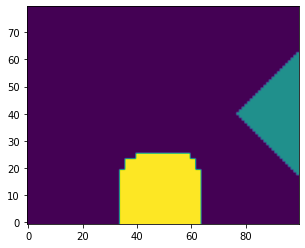

In [48]:
#Inlets and outlets
np.savetxt('inputs/gottesacker/inlets3D.txt',inlets3D,fmt='%.1f') #save 3D inlets
np.savetxt('inputs/gottesacker/outlets3D.txt',outlets3D,fmt='%.1f')

#Topography DEM
a = dem.copy()
a = np.rot90(a)
a = np.flipud(a)
print(dem.shape, a.shape)
#plt.imshow(a, origin='lower')
np.savetxt('inputs/valley1/dem'+str(a.shape[0])+'x'+str(a.shape[1])+'.csv', a, delimiter=',')  #export DEM as csv

#Geologic contact surface (bottom of karst)
a = zcontact.copy()
a = np.rot90(a)
a = np.flipud(a)
print(zcontact.shape, a.shape)
#plt.imshow(a, origin='lower')
np.savetxt('inputs/valley1/contact'+str(a.shape[0])+'x'+str(a.shape[1])+'.csv', a, delimiter=',')  #export as csv

#2D geologic map
a = geomap.copy()
a = np.rot90(a)
a = np.flipud(a)
print(geomap.shape, a.shape)
plt.imshow(a, origin='lower')
np.savetxt('inputs/valley1/geo'+str(a.shape[0])+'x'+str(a.shape[1])+'.csv', a, delimiter=',')  #export 2D geologic map as csv

#3D geologic map
#to VTK for visualization
print(geocrop.shape)
export2vtk(xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres, 
           'inputs/valley1/geo'+str(geocrop.shape[0])+'x'+str(geocrop.shape[1])+'x'+str(geocrop.shape[2]), 
            geocrop)

In [39]:
np.unique(geo)

array([0, 1, 2, 3, 4], dtype=int64)

Contact array: (251, 200) 800.0 2092.5


C:\Users\Chloe\Anaconda3\envs\agd-hfm-pykasso\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 0, 'Contact surface')

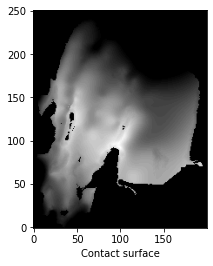

In [54]:
#Extract contact surface from geology array:
limestone = 2   #contact describes bottom surface of this unit
shale = 3       #this is the unit below the limeston (contact describes upper surface of this unit)
older = 4       #this is the unit below the shale
zcontact = np.zeros((xres,yres), dtype='float')
for ix in range(xres):
    for iy in range(yres):
        for iz in range(zres):
            #if (geo[ix,iy,iz] == 0) and (geo[ix,iy,iz-1] != 0): #if current cell is zero but cell below is not, store elevation
                #[x,y,z] = index2point([ix,iy,iz-1], xmin,ymin,zmin, dx,dy,dz)
                #zcontact[ix,iy] = z
            #if (geo[ix,iy,iz] == older) and (geo[ix,iy,iz+1] != shale):  #top of older units : if current cell is older but cell above is not, store elevation 
                #[x,y,z] = index2point([ix,iy,iz-1], xmin,ymin,zmin, dx,dy,dz)
                #zcontact[ix,iy] = z
            if (geo[ix,iy,iz] == shale) and (geo[ix,iy,iz+1] != shale):  #top of shale: if current cell is shale but cell above is not, store elevation 
                [x,y,z] = index2point([ix,iy,iz-1], xmin,ymin,zmin, dx,dy,dz)
                zcontact[ix,iy] = z
            if (geo[ix,iy,iz] == limestone) and (geo[ix,iy,iz-1] != limestone):  #bottom of limestone: if current cell is ls but cell below it is not, store elevations
                [x,y,z] = index2point([ix,iy,iz-1], xmin,ymin,zmin, dx,dy,dz)
                zcontact[ix,iy] = z
            
            
zcontact[zcontact < zmin] = zmin #if any cells have values lower than bottom of model, replace with minimum z value
print('Contact array:', zcontact.shape, np.nanmin(zcontact), np.nanmax(zcontact))
f.add_subplot(153, aspect='equal')
plt.imshow(zcontact, origin='lower', cmap='gray') #white = limestone
plt.xlabel('Contact surface')

In [55]:
#Export Geologic contact surface (bottom of karst)
a = zcontact.copy()
a = np.rot90(a)
#a = np.flipud(a)
print(zcontact.shape, a.shape)
print(np.unique(a))
#plt.imshow(a, origin='lower')
np.savetxt('inputs/gottesacker/contact'+str(a.shape[0])+'x'+str(a.shape[1])+'.csv', a, delimiter=',')  #export as csv

(251, 200) (200, 251)
[ 800.   827.5  855.   882.5  910.   937.5  965.   992.5 1020.  1047.5
 1075.  1102.5 1130.  1157.5 1185.  1212.5 1240.  1267.5 1295.  1322.5
 1350.  1377.5 1405.  1432.5 1460.  1487.5 1515.  1542.5 1570.  1597.5
 1625.  1652.5 1680.  1707.5 1735.  1762.5 1790.  1817.5 1845.  1872.5
 1900.  1927.5 1955.  1982.5 2010.  2037.5 2065.  2092.5]


In [34]:
#3D geologic map
#to VTK for visualization
g = geo.copy()
g = np.fliplr(g)
#g = np.flipud(g)
print(g.shape)
export2vtk(xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres, 
           'inputs/gottesacker/geo'+str(g.shape[0])+'x'+str(g.shape[1])+'x'+str(g.shape[2]), 
            g)

(251, 200, 52)


(100, 80, 60) (60, 80, 100) [0 1 2 3]


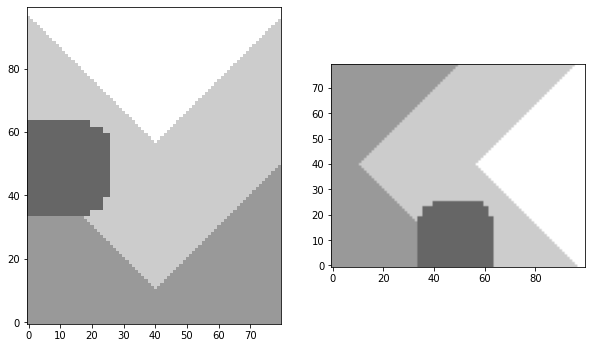

In [6]:
#GSLIB export

#3D
#Reformat
a = geocrop.copy()
a = np.rot90(a)            #rotate 90 degrees clockwise (swap x and y)
a = np.flipud(a)          #flip values across centerline of y axis
a = np.moveaxis(a, -1, 0) #move z axis to be in first position
a = a.astype(int)         #convert from floats to integers
print(geocrop.shape, a.shape, np.unique(a))   #now the array has dim (zres,yres,xres)
f = plt.figure(figsize=(10,15))
f.add_subplot(121, aspect='equal')
plt.imshow(geocrop[:,:,30], origin='lower', cmap='gray_r', vmin=0,vmax=5)
f.add_subplot(122, aspect='equal')
plt.imshow(a[30,:,:], origin='lower', cmap='gray_r', vmin=0,vmax=5)

#Export
a1 = np.reshape(a, xres*yres*zres, order='F')    #reshape 3D array to 1D array using Fortran indexing 
df = pd.DataFrame(a1)                                #store array in a pandas dataframe
header = pd.DataFrame(['Geologic model',1,'lith'])  #set gslib file header
df = header.append(df)                              #attach header and data
df.to_csv('inputs/valley1/geo'+str(a.shape[0])+'x'+str(a.shape[1])+'x'+str(a.shape[2])+'.gslib', header=False, index=False)      #write a text file in gslib format

(60, 80, 100)


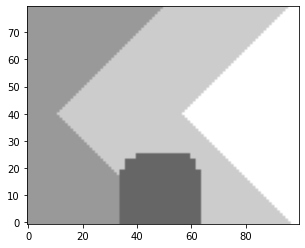

In [47]:
#Test gslib by re-importing:
a = pd.read_csv('inputs/valley1/geo60x80x100.gslib', skiprows=2)  #read in gslib file to pandas df without header rows
a = a.values                                        #get an array of the values
a = np.reshape(a,(zres,yres,xres),order='F') #reshape to xyz grid using Fortran ordering

print(a.shape)
plt.imshow(a[30,:,:], origin='lower', cmap='gray_r', vmin=0,vmax=5)


(100, 80) (80, 100) [1 2 3]


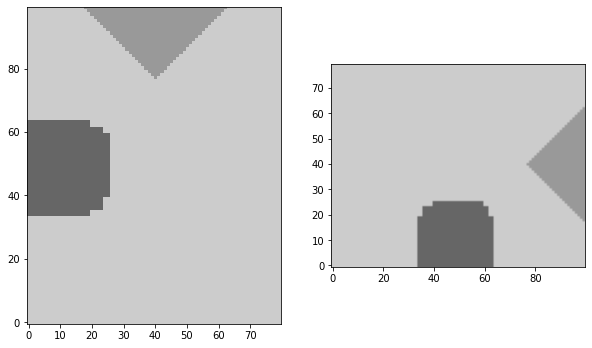

In [7]:
#GSLIB export

#3D
#Reformat
a = geomap.copy()
a = np.rot90(a)            #rotate 90 degrees clockwise (swap x and y)
a = np.flipud(a)          #flip values across centerline of y axis
a = a.astype(int)         #convert from floats to integers
print(geomap.shape, a.shape, np.unique(a))   #now the array has dim (zres,yres,xres)
f = plt.figure(figsize=(10,15))
f.add_subplot(121, aspect='equal')
plt.imshow(geomap, origin='lower', cmap='gray_r', vmin=0,vmax=5)
f.add_subplot(122, aspect='equal')
plt.imshow(a, origin='lower', cmap='gray_r', vmin=0,vmax=5)

#Export
a1 = np.reshape(a, xres*yres, order='F')    #reshape 3D array to 1D array using Fortran indexing 
df = pd.DataFrame(a1)                                #store array in a pandas dataframe
header = pd.DataFrame(['Geologic model',1,'lith'])  #set gslib file header
df = header.append(df)                              #attach header and data
df.to_csv('inputs/valley1/geo'+str(a.shape[0])+'x'+str(a.shape[1])+'.gslib', header=False, index=False)      #write a text file in gslib format

(80, 100)


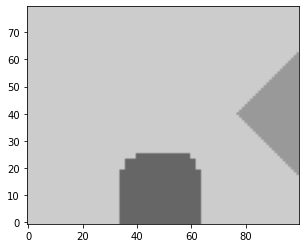

In [8]:
#Test gslib by re-importing:
a = pd.read_csv('inputs/valley1/geo80x100.gslib', skiprows=2)  #read in gslib file to pandas df without header rows
a = a.values                                        #get an array of the values
a = np.reshape(a,(yres,xres),order='F') #reshape to xyz grid using Fortran ordering

print(a.shape)
plt.imshow(a, origin='lower', cmap='gray_r', vmin=0,vmax=5)

## 2D ##

flat DEM array: (80, 100) 600.0 600.0
DEM array: (80, 100) 252.5 600.0
Geology array: (80, 100) 1 2
Cost array: (80, 100) 0.4 0.9


Text(0.5, 0, 'Cost array')

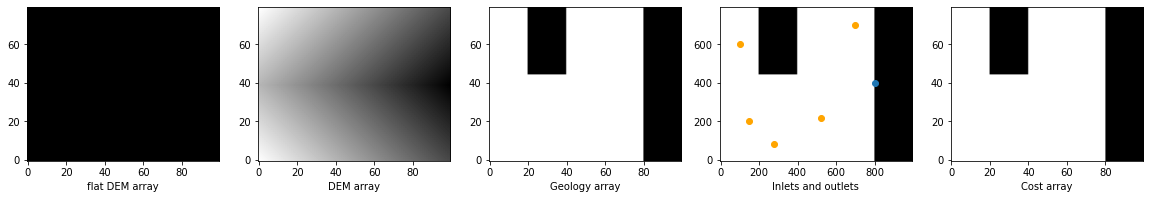

In [4]:
#Create 2D flat topography array for comparison:
flat = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
flat = np.rot90(flat)
print('flat DEM array:', flat.shape, flat.min(), flat.max())    #print dimensions
#np.savetxt('flat_'+str(flat.shape[0])+'x'+str(flat.shape[1])+'.csv', flat, delimiter=',')  #export as csv
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.imshow(flat, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('flat DEM array')

#Create 2D topography array:
dem = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):               #move west to east along x indices (columns)
    dem[ix,:] = mx*ix + dem[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):     #move down rows towards valley (north to south)
        dem[ix,iy] = my*iy + dem[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):            #move down y indices (rows) away from valley (south to north)
    dem[:,iy] = dem[:,yres-iy]           #insert a mirror image of the north side of the valley
dem = np.rot90(dem)                      #flip to have correct format for pykasso/agd-hfm
#dem = np.fliplr(dem)                     #optional - if want to have valley going the other direction
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
np.savetxt('dem_'+str(dem.shape[0])+'x'+str(dem.shape[1])+'.csv', dem, delimiter=',')  #export as csv
f.add_subplot(152, aspect='equal')
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')

#Create 2D geology array:
limestone = 1
shale     = 2
geo = np.full((xres,yres), limestone)   #set 3D array of model dimensions filled with limestone value
geo[20:40, 0:35] = shale                #insert a block of shale in one corner to make array asymmetrical
geo[80:]        = shale                 #make one end shale
geo = np.rot90(geo)
print('Geology array:', geo.shape, geo.min(), geo.max())   
#np.savetxt('geo'+str(geo.shape[0])+'x'+str(geo.shape[1])+'.csv', geo, delimiter=',')  #export as csv
f.add_subplot(153, aspect='equal')
plt.imshow(geo, origin='lower', cmap='gray_r') #white = limestone
plt.xlabel('Geology array')

#Define 2D inlets and outlets:
inlets  = np.asarray([[100,600],[150,200],[520,220],[280,80],[700,700]])
outlets = np.asarray([[800,400]])
#np.savetxt("inlets.csv",  inlets,  delimiter=',')  #export as csv
#np.savetxt("outlets.csv", outlets, delimiter=',')  #export as csv
f.add_subplot(154, aspect='equal')
plt.imshow(geo, origin='lower', extent =[xmin,xmax,ymin,ymax], cmap='gray_r') #white = limestone
plt.xlabel('Inlets and outlets')
plt.scatter(inlets[:,0],  inlets[:,1], c='orange')
plt.scatter(outlets[:,0], outlets[:,1])

#Create 2D cost field:
Ckarst    = 0.4    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.9    #travel cost in nonkarst unit (should be high)
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full((xres,yres), Ckarst)    #set up array of default cost values (must be rotated 90 degrees to match geo array)
cost = np.rot90(cost)
cost[geo==1] = Ckarst     #assign low cost to limestone (2)
cost[geo==2] = Cnonkarst  #assign medium-high cost to all non-karst units
print('Cost array:', cost.shape, cost.min(), cost.max())    #print dimensions
#np.savetxt('cost'+str(cost.shape[0])+'x'+str(cost.shape[1])+'.csv', cost, delimiter=',')  #export as csv
f.add_subplot(155, aspect='equal')
plt.imshow(cost, origin='lower', cmap='gray_r') #darker=higher cost
plt.xlabel('Cost array')

## Random topography generator

Modified from https://github.com/hnhaefliger/pyTerrain

DEM array: (200, 251) -7.084366106804626 199.18932614001508


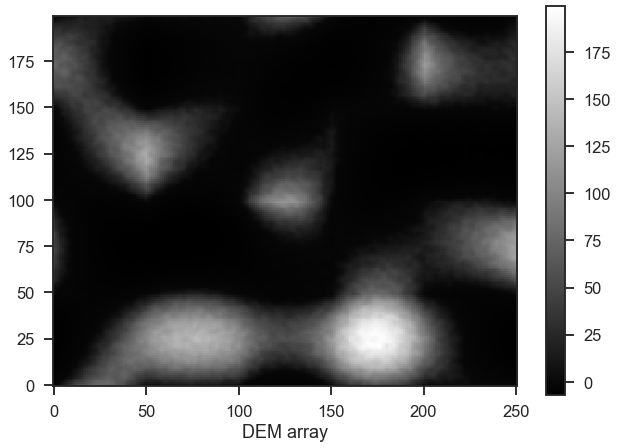

In [132]:
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyTerrain') #path to local version of package
import perlin             #in this case, "perlin" is the name of the .py file with all of the functions in it

width  = xres # map width
length = yres # map length

############ Noise variables

n1div = 50 # landmass distribution (default: 30)  higher=fewer,larger landmasses
n2div = 4  # boulder distribution  (default: 4)   higher=fewer boulders
n3div = 2  # rock distribution     (default: 1)   higher=fewer rocks?

n1scale = zres  # landmass height    (default: 20) #highest possible elevation
n2scale = 4   # boulder scale      (default: 2)
n3scale = 1   # rock scale         (default: 0.5)

noise1 = perlin.noise(width / n1div, length / n1div) # landmass / mountains
noise2 = perlin.noise(width / n2div, length / n2div) # boulders
noise3 = perlin.noise(width / n3div, length / n3div) # rocks

zroot = 2          #default: 2   abruptness of landmass boundary? higher=more gradual
zpower = 2.5       #default: 2.5

#Create topography:
points = []
#for x in range(-int(width/2), int(width/2)):
    #for y in range(-int(length/2), int(length/2)):
for x in np.arange(-(width/2), (width/2)):
    for y in np.arange(-(length/2), (length/2)):      #correct for arrays with odd dimensions
        x1 = x + width/2 
        y1 = y + length/2
        z = noise1.perlin(x1 / n1div, y1 / n1div) * n1scale # add landmass
        z += noise2.perlin(x1 / n2div, y1 / n2div) * n2scale # add boulders
        z += noise3.perlin(x1 / n3div, y1 / n3div) * n3scale # add rocks
        if z >= 0:
            z = -math.sqrt(z)
        else:
            z = ((-z) ** (1 / zroot)) ** zpower
        points.append([x, y, z]) 
        
#Reformat into array, view, & export:
df = pd.DataFrame(points, columns=['x','y','z'])             #convert to df to be able to use pivot table feature
table = df.pivot_table(values='z', index='x', columns='y')   #convert (x,y,z) to a table of dim (x,y) with values z
dem = table.to_numpy()                                       #convert to numpy array for viewing and export

dem = np.rot90(dem)                      #flip to have correct format for pykasso/agd-hfm
#dem = np.fliplr(dem)                    #optional - if want to change x alignment
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
np.savetxt('random_dem'+str(dem.shape[0])+'x'+str(dem.shape[1])+'.csv', dem, delimiter=',')  #export as csv
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')
plt.colorbar()

## Use GemPy

In [133]:
import random
import gdal
import matplotlib
import gempy as gp

In [134]:
def importDEM(filename, show=True):
    '''Import DEM from a tif file using gdal package.
    Return a dem object, and xyz extent and resolution.
    (this can be used to set the model extent)
    NOTE: vertical (z) resolution can't be extracted from the raster!
    
    filename: string indicating the filename (must be a rectangular tif)
    show:     option to show a plot of the DEM or not.
    
    Returns:     grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  

    dem:      gdal dem objecct
    dema:     array of elevation values of dim: xres,yres
    xmin:     minimum x value (same for ymin, zmin)
    xmax:     maximum x value (same for ymax, zmax)
    xres:     x resolution, aka number of columns, aka number of cells along x axis (NOT pixel width)
    dx:       pixel width in x direction 
    etc.
    '''
    
    dem = gdal.Open(filename)    #DEM must be rectangular tif 
    dema = dem.ReadAsArray()     #copy of DEM as a numpy array (defaults to integers)
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (have to convert array to float first)

    ulx, pixelwidthx, xskew, uly, yskew, pixelheighty = dem.GetGeoTransform() #get resolution and coordinate info (for some reason the order of skew and pixel size is flipped for y axis?!)
    ncol = dem.RasterXSize            #number of columns (aka number of cells along x axis)
    nrow = dem.RasterYSize            #number of rows (aka number of cells along y axis)
    lrx = ulx + (ncol * pixelwidthx)  #lower right x coord = upper left x coord + (width of raster cells in x direction * number of raster cells in x direction)
    lry = uly + (nrow * pixelheighty)

    #Get min and max elevations (z):
    #note: gdal's built-in GetRasterBand and GetStatistics return an incorrect zmin (WHY?!)
    zmin = np.nanmin(dema)
    zmax = np.nanmax(dema)
    
    #Assign useful names:
    xmin = ulx
    xmax = lrx
    xres = ncol
    dx =   abs(pixelwidthx)
    ymin = lry
    ymax = uly
    dy =   abs(pixelheighty)
    yres = nrow
    zres = 'na'     #can't be extracted from raster

    #Print results & display raster:
    if show==True:
        print('Raster dimensions: \nxmin: {:<12} xmax: {:<12} xres: {} \nymin: {:<12} ymax: {:<12} yres: {} \nzmin: {:<12} zmax: {:<12} zres: {}'.format(
            xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres))
        plt.imshow(dema, extent=(xmin,xmax,ymin,ymax), vmin=zmin, vmax=zmax) #plot raster as image
        #print(gdal.Info(dem))  #for more detailed file info, uncomment this line
        
    return dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres

Starting GemPy run...
Grid dimensions: 
xmin: 578287.5     xmax: 590837.5     xres: 251          dx: 50.0 
ymin: 5240062.5    ymax: 5250062.5    yres: 200          dy: 50.0 
zmin: 800          zmax: 2230.0       zres: 52           dz: 27.5
Compiling theano function...
Compilation Done!
Done with GemPy run.


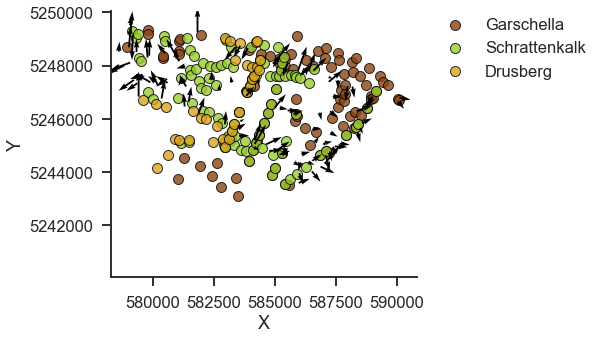

In [136]:
print('Starting GemPy run...')
import gempy as gp

#Get and assign model grid and resolution automatically based on DEM raster file:
dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = importDEM('inputs/gottesacker/dem251x200.tif',show=False) 
zmin = 800                  #manually set zmin so that model extends below land surface - must be integer
zres = 52                   #set vertical (z) resolution (number of layers) from parameter dic & manually assign it (this has nothing to do with dem resolution)
dz = (zmax-zmin)/zres       #calculate z cell height (kind of like contour interval)
grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  #lump grid and resolution info into one list to use later
print('Grid dimensions: \nxmin: {:<12} xmax: {:<12} xres: {:<12} dx: {} \nymin: {:<12} ymax: {:<12} yres: {:<12} dy: {} \nzmin: {:<12} zmax: {:<12} zres: {:<12} dz: {}'.format(
    xmin,xmax,xres,dx, ymin,ymax,yres,dy, zmin,zmax,zres,dz))

#Create model object & assign unit names and order:
geo_model = gp.create_model('Gottesacker')                                    #create model object
gp.init_data(geo_model, [xmin,xmax, ymin,ymax, zmin,zmax], [xres,yres,zres],  #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
            path_o = 'inputs/gottesacker/gempy_orientations.csv',                                #csv file for orientation points: col names are case sensitive, must include at least one point per unit t
            path_i = 'inputs/gottesacker/gempy_interfaces.csv')                                  #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit (except faults)

unitNames = ['Garschella', 'Schrattenkalk', 'Drusberg']     #list of unit names to use, youngest (uppermost) to oldest (bottommost)
gp.map_series_to_surfaces(geo_model, {'strat': unitNames})  #set the correct order of series, youngest to oldest

#Set grids:
#geo_model.set_topography(source='gdal', filepath='inputs/gottesacker/dem251x200.tif')      #load surface topography from DEM
#geo_model.grid.set_active('topography')                                          #need to activate both topo and regular grid to visualize in VTK
geo_model.grid.set_active('regular')

#Set custom colors for different units (optional):
surfaces = geo_model.surfaces                                                #get surfaces in the model
colordic = {'Garschella':    matplotlib.colors.cnames['saddlebrown'],        #create custom color dictionary
            'Schrattenkalk': matplotlib.colors.cnames['yellowgreen'],
            'Drusberg':      matplotlib.colors.cnames['goldenrod'],
            'basement':      matplotlib.colors.cnames['rebeccapurple']} 
surfaces.colors.change_colors(colordic)                                      #assign new colors

#View model setup (optional):
show=True
if show==True:
    gp.plot.plot_data(geo_model, direction='z') #plot a map view of the data points
    geo_model.surfaces                          #see order of surfaces (series and formations)

#Calculate model: (only need to interpolate once)
#if using topography, need to set output='geology'
#for high-resolution models with many data points, set theano_optimizer='fast_run' instead of 'fast_compile' - this takes longer to interpolate, but then afterwards runs faster & avoids theano memory error during compute_model()
#gp.set_interpolation_data(geo_model, output='geology', theano_optimizer='fast_run') #compile theano and interpolate the input data
gp.set_interpolation_data(geo_model, output='geology', theano_optimizer='fast_run') #compile theano and interpolate the input data
sol = gp.compute_model(geo_model, compute_mesh=True)   #compute the model from the data - returns an output (sol) which includes lith and faults, each with two arrays, one for the id of the formation in each cell, one with orientations in each cell
#to see 3D VTK visualization of interfaces, set compute_mesh=True. To return only the lith block, set compute_mesh=False (this works even if xres ≠ yres)

#Format & export data:
#lithZcrop  = crop2topo(  sol, 'inputs/gottesacker/dem251x200.tif')         #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
#lithXYcrop = crop2raster(sol, 'maskraster50_251x200.tif',     a=lithZcrop)   #crop topo-cropped array to extent of geol map from raster
#export2gslib(lithXYcrop, 'outputs/gottesacker/gempy'+str(xres)+'x'+str(yres)+'.gslib', sol.grid.regular_grid)    #export cropped lith block as gslib for conduit generation

print('Done with GemPy run.')

In [111]:
#Get 2D geologic map (only works if output is set to 'geology', topography is turned on, and compute_mesh=False)a
m = sol.geological_map
print(m.shape)
m = np.reshape(m,(yres,xres) )
#plt.imshow(m, origin='lower')

(2610400,)


AttributeError: 'NoneType' object has no attribute 'shape'

(2610400,)
Lith: (251, 200, 52) 0.9999999999999999 4.0
(1, 2610400)
Scalar matrix: (251, 200, 52) 0.9683958491399043 1.2744414721360946
DEM indices: (251, 200) 3 51
Scalar map: (251, 200) 0.9751783611481333 1.2538776140484358
Geo map: (251, 200) 0.9999999999999999 4.0


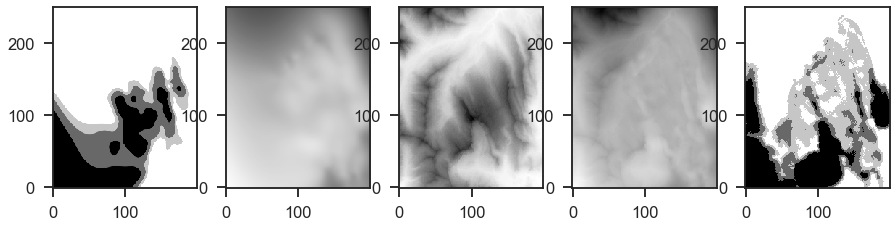

In [192]:
f = plt.figure(figsize=(15,10))

#Get 3D lithology:
a = sol.lith_block
print(a.shape)
lith = np.reshape(a,(xres,yres,zres) )
print('Lith:', lith.shape, lith.min(), lith.max())
f.add_subplot(151)
plt.imshow(lith[:,:,30], origin='lower')

#Get 3D scalar field:
a = sol.scalar_field_matrix
print(a.shape)
scalar_matrix = np.reshape(a,(xres,yres,zres) )
print('Scalar matrix:', scalar_matrix.shape, scalar_matrix.min(), scalar_matrix.max())
f.add_subplot(152)
plt.imshow(scalar_matrix[:,:,10], origin='lower')

#Convert DEM from elevations to z cell indices:
demr = np.rot90(dema,k=3)
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(demr[:,iy]):
        [xind,yind,zind] = point2index((ix,iy,z), xmin,ymin,zmin, dx,dy,dz) #use new fn to convert to indices
        idem[ix,iy] = zind-1 #correct to be index below
print('DEM indices:', idem.shape, idem.min(), idem.max())
f.add_subplot(153)
plt.imshow(idem, origin='lower')

#Extract values at land surface:
scalar_map = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        scalar_map[ix,iy] = scalar_matrix[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface
print('Scalar map:', scalar_map.shape, scalar_map.min(), scalar_map.max())
f.add_subplot(154)
plt.imshow(scalar_map, origin='lower')

#Extract lithology at land surface:
geo_map = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        geo_map[ix,iy] = lith[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface
print('Geo map:', geo_map.shape, geo_map.min(), geo_map.max())
f.add_subplot(155)
plt.imshow(geo_map, origin='lower')


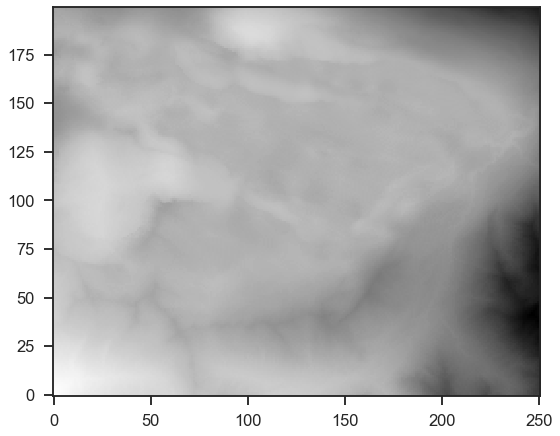

In [194]:
#Export:
scalar_map2 = np.flipud(np.rot90(scalar_map,k=1))
plt.imshow(scalar_map2, origin='lower')
np.savetxt('scalar_map'+str(scalar_map2.shape[0])+'x'+str(scalar_map2.shape[1])+'.csv', scalar_map2, delimiter=',')  #export as csv


## Extra stuff ##

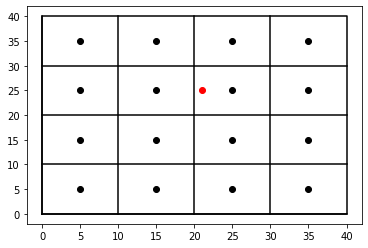

In [59]:
#Visualize grid:

xmin = 0;  dx = 10.;  xres = 4;  xmax = xmin + xres*dx
ymin = 0;  dy = 10.;  yres = 4;  ymax = ymin + yres*dy

xpoints  = np.linspace(xmin,          xmax-dx,       xres)   #left corners
xcenters = np.linspace(xmin + (dx/2), xmax - (dx/2), xres)   #centerpoints
ypoints  = np.linspace(ymin,          ymax-dx,       yres)   #bottom corners
ycenters = np.linspace(ymin + (dy/2), ymax - (dx/2), yres)   #centerpoints
X,Y      = np.meshgrid(xcenters,ycenters)

plt.scatter(X,Y, c='k')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin], c='k')
for i in range(xres):
    plt.plot([xpoints[i],xpoints[i]],[ymin,ymax], c='k')
for j in range(yres):
    plt.plot([xmin,xmax],[ypoints[j],ypoints[j]], c='k')

x = 21; y = 25
plt.scatter(x,y, c='r')
